# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve
import ssl

In [2]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
ssl._create_default_https_context = ssl._create_unverified_context
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        if word in self.words:
            id = self.word2id[word]
            emb = self.embeddings[id,:]
        else:
            emb = np.zeros(300)
        return emb
    
    def score(self, word1, word2):
        # Returns the cosine similarity: use np.dot & np.linalg.norm
        embedding1 = self.encode(word1)
        embedding2 = self.encode(word2)
        return np.dot(embedding1, embedding2)/(np.linalg.norm(embedding1)*np.linalg.norm(embedding2))
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 
        scores = []
        for word2 in self.words:
            scores.append(self.score(word, word2))
        ids = np.argsort(scores)
        len = ids.shape[0]
        similars = []
        for i in range(1,k+1):
            idx = ids[len-i]
            similars.append(self.id2word[idx])
        return(similars)

In [4]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542564
cat pet 0.6753313359976382
Paris France 0.6892958925806543
Paris Germany 0.4051242286737549
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348003
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'pup', 'canine']
['dogs', 'dog', 'cats', 'puppies', 'Dogs']
['Paris', 'France', 'Parisian', 'Marseille', 'Brussels']
['Germany', 'Austria', 'Europe', 'Berlin', 'Hamburg']


In [5]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        nbsentences = len(sentences)
        idf = {}
        for sentence in sentences:
                wordsentence = sentence.split()
                for word in wordsentence:
                    if word in idf.keys():
                        idf[word] += 1
                    else:
                        idf[word] = 1
        for word in idf.keys():
            idf_value = np.log(nbsentences/idf[word])
            idf[word] = idf_value
        return idf
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        wordsentence = sentence.split( )
        wordsembeddings = []
        for word in wordsentence:
            wordsembeddings.append(self.word2vec.encode(word))
        if idf is None:
            # mean of word vectors
            return np.average(wordsembeddings, axis=0)
        else:
            # idf-weighted mean of word vectors
            weights = []
            for word in wordsentence:
                weights.append(idf[word])
            return np.average(wordsembeddings, weights = weights, axis=0) 
                
    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        embedding1 = self.encode(sentence1, idf)
        embedding2 = self.encode(sentence2, idf)
        return np.dot(embedding1, embedding2)/(np.linalg.norm(embedding1)*np.linalg.norm(embedding2))
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Returns most similar sentences
        query = self.encode(sentence, idf)
        keys = np.vstack([self.encode(sentence, idf) for sentence in sentences])
        scores = [np.dot(query, key)/(np.linalg.norm(query)*np.linalg.norm(key)) for key in keys]
        ids = np.argsort(scores)
        len = ids.shape[0]
        similars = []
        for i in range(1,k+1):
            id = ids[len-i]
            similars.append(sentences[id])
        return(similars)
        

In [6]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
sentence = sentences[10] #added by me
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251475
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 2 woman dancing while pointing . 
3) 5 women and 1 man are smiling for the camera . 
4) a small boy following 4 geese . 
5) 2 female babies eating chips . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6230172138542661
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 1 man singing and 1 man playing a saxophone in a concert . 
3) two women and 1 man walking across the street . 
4) 2 guys facing away from camera , 1 girl smiling at camera with blue shirt , 1 guy with a beverage with a jacket on . 
5) 5 women and 1 man are smiling for the camera . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        X, Y = [], []
        for word in self.fr_word2vec.words:
            if word in self.en_word2vec.words:
                X.append(self.fr_word2vec.encode(word))
                Y.append(self.en_word2vec.encode(word))
        X, Y = np.asarray(X).transpose(), np.asarray(Y).transpose()
        assert X.shape[0] == 300 and Y.shape[0] == 300
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        a = np.matmul(Y, X.transpose())
        u, s, vh = np.linalg.svd(a)
        W = np.matmul(u, vh)
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        id = self.fr_word2vec.word2id[fr_word]
        emb_eq_en_word = self.aligned_fr_embeddings[id,:]
        scores = [np.dot(emb_eq_en_word, emb)/(np.linalg.norm(emb_eq_en_word)*np.linalg.norm(emb)) for emb in self.en_word2vec.embeddings]
        ids = np.argsort(scores)
        len = ids.shape[0]
        similars = []
        for i in range(1,k+1):
            idx = ids[len-i]
            similars.append(self.en_word2vec.id2word[idx])
        return(similars)

In [8]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [9]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

with open(train_filepath, 'r') as f:
    train = [line.strip('\n') for line in f]
    x_train = [x[2:] for x in train]
    y_train = [int(x[0]) for x in train]
    print('length of the train set: ')
    print(len(x_train))

with open(dev_filepath, 'r') as f:
    dev = [line.strip('\n') for line in f]
    x_dev = [x[2:] for x in dev]
    y_dev = [int(x[0]) for x in dev]
    print('length of the dev set: ')
    print(len(x_dev))

with open(test_filepath, 'r') as f:
    x_test = [line.strip('\n') for line in f]
    print('length of the test set: ')
    print(len(x_test))


length of the train set: 
8544
length of the dev set: 
1101
length of the test set: 
2210


In [10]:
# 2 - Encode sentences with the BoV model above
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

idfxtrain = sentence2vec.build_idf(x_train)
x_train_emb = [sentence2vec.encode(sentence) for sentence in x_train]
x_train_emb_weight = [sentence2vec.encode(sentence, idfxtrain) for sentence in x_train]

idfxdev = sentence2vec.build_idf(x_dev)
x_dev_emb = [sentence2vec.encode(sentence) for sentence in x_dev]
x_dev_emb_weight = [sentence2vec.encode(sentence, idfxdev) for sentence in x_dev]

idfxtest = sentence2vec.build_idf(x_test)
x_test_emb = [sentence2vec.encode(sentence) for sentence in x_test]
x_test_emb_weight = [sentence2vec.encode(sentence, idfxtest) for sentence in x_test]

Loaded 50000 pretrained word vectors


In [29]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

print("Using the average of word vectors")
clf = LogisticRegression(penalty='l2', solver='newton-cg', multi_class='multinomial')

C_vals = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

dev_acc = []
for C in C_vals:
    clf_C = LogisticRegression(penalty='l2', C = C, multi_class='multinomial', solver='newton-cg')
    clf_C.fit(x_train_emb, y_train)
    dev_acc.append(clf_C.score(x_dev_emb, y_dev))
C_best = C_vals[np.argmax(dev_acc)]
print("Best C : {}".format(C_best))

clf = LogisticRegression(penalty='l2', solver='newton-cg', multi_class='multinomial', C = C_best)
clf = clf.fit(x_train_emb, y_train)
print("Dev score using average : {}".format(clf.score(x_dev_emb, y_dev)))
print("Training score using average : {}".format(clf.score(x_train_emb, y_train)))


print("\nUsing the weighted-average of word vectors")
clfw = LogisticRegression(penalty='l2', solver='newton-cg', multi_class='multinomial')

C_vals = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

dev_acc = []
for C in C_vals:
    clfw_C = LogisticRegression(penalty='l2', C = C, multi_class='multinomial', solver='newton-cg')
    clfw_C.fit(x_train_emb_weight, y_train)
    dev_acc.append(clfw_C.score(x_dev_emb_weight, y_dev))
C_best = C_vals[np.argmax(dev_acc)]
print("Best C : {}".format(C_best))

clfw = LogisticRegression(penalty='l2', solver='newton-cg', multi_class='multinomial', C = C_best)
clfw = clfw.fit(x_train_emb_weight, y_train)
print("Dev score using weighted-average : {}".format(clfw.score(x_dev_emb_weight, y_dev)))
print("Training score using weighted-average : {}".format(clfw.score(x_train_emb_weight, y_train)))



## Other method: tuning the L2 regularization by grid search

# from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import GridSearchCV

#print("Using the average of word vectors")
#clf = LogisticRegression(penalty='l2', solver='newton-cg', multi_class='multinomial')

#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
#grid = GridSearchCV(estimator=clf, param_grid=param_grid)
#grid.fit(x_train_emb, y_train)
#print("Best score grid : {}".format(grid.best_score_))
#print("Best C grid : {}".format(grid.best_estimator_.C))

#clf = LogisticRegression(penalty='l2', solver='newton-cg', multi_class='multinomial', C = grid.best_estimator_.C)
#clf = clf.fit(x_train_emb, y_train)
#print("Dev score using average : {}".format(clf.score(x_dev_emb, y_dev)))
#print("Training score using average : {}".format(clf.score(x_train_emb, y_train)))


#print("\nUsing the weighted-average of word vectors")
#clfw = LogisticRegression(penalty='l2', solver='newton-cg', multi_class='multinomial')

#grid = GridSearchCV(estimator=clfw, param_grid=param_grid)
#grid.fit(x_train_emb_weight, y_train)
#print("Best score grid : {}".format(grid.best_score_))
#print("Best C grid : {}".format(grid.best_estimator_.C))

#clfw = LogisticRegression(penalty='l2', solver='newton-cg', multi_class='multinomial', C = grid.best_estimator_.C)
#clfw = clfw.fit(x_train_emb_weight, y_train)
#print("Dev score using weighted-average : {}".format(clfw.score(x_dev_emb_weight, y_dev)))
#print("Training score using weighted-average : {}".format(clfw.score(x_train_emb_weight, y_train)))



Using the average of word vectors
Best C : 10
Dev score using average : 0.41689373297002724
Training score using average : 0.46594101123595505

Using the weighted-average of word vectors
Best C : 10
Dev score using weighted-average : 0.4141689373297003
Training score using weighted-average : 0.4708567415730337


In [30]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

clf = LogisticRegression(penalty='l2', solver='newton-cg', multi_class='multinomial', C = 10)
clf = clf.fit(np.vstack((x_train_emb, x_dev_emb)), np.concatenate((y_train, y_dev)))
pred = clf.predict(x_test_emb)
f = open('logreg_bov_y_test_sst.txt', 'w')
for item in pred:
    f.write("%s\n" % item) 
f.close()
        

In [32]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

print('-----Random Forest-----')
from sklearn.ensemble import RandomForestClassifier

clf2 = RandomForestClassifier(n_estimators = 100)
print("Using the average of word vectors")
clf2 = clf2.fit(x_train_emb, y_train)
print("Dev score using average : {}".format(clf2.score(x_dev_emb, y_dev)))
print("Training score using average : {}".format(clf2.score(x_train_emb, y_train)))

print("Using the weighted-average of word vectors")
clf2 = clf2.fit(x_train_emb_weight, y_train)
print("Dev score using weighted-average : {}".format(clf2.score(x_dev_emb_weight, y_dev)))
print("Training score weighted-using average : {}".format(clf2.score(x_train_emb_weight, y_train)))



print('\n-----SVM-----')
from sklearn import svm

clf3 = svm.SVC(gamma='scale')
print("Using the average of word vectors")
clf3 = clf3.fit(x_train_emb, y_train)
print("Dev score using average : {}".format(clf3.score(x_dev_emb, y_dev)))
print("Training score using average : {}".format(clf3.score(x_train_emb, y_train)))

print("Using the weighted-average of word vectors")
clf3 = clf3.fit(x_train_emb_weight, y_train)
print("Dev score using weighted-average : {}".format(clf3.score(x_dev_emb_weight, y_dev)))
print("Training score using average : {}".format(clf3.score(x_train_emb_weight, y_train)))

print('\nTUNING')
print("Using the average of word vectors")
param_grid = {'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1],
              'C': [0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(svm.SVC(kernel = 'rbf'), param_grid, cv=3)
grid.fit(x_train_emb, y_train)
print(grid.best_params_)
clf3 = grid.best_estimator_
clf3 = clf3.fit(x_train_emb, y_train)
print("Dev score using average : {}".format(clf3.score(x_dev_emb, y_dev)))
print("Training score using average : {}".format(clf3.score(x_train_emb, y_train)))

print("Using the weighted-average of word vectors")
param_grid = {'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1],
                     'C': [0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(svm.SVC(kernel = 'rbf'), param_grid, cv=3)
grid.fit(x_train_emb_weight, y_train)
print(grid.best_params_)
clf3w = grid.best_estimator_
clf3w = clf3w.fit(x_train_emb_weight, y_train)
print("Dev score using weighted-average : {}".format(clf3w.score(x_dev_emb_weight, y_dev)))
print("Training score using weighted-average : {}".format(clf3w.score(x_train_emb_weight, y_train)))

-----Random Forest-----
Using the average of word vectors
Dev score using average : 0.335149863760218
Training score using average : 0.9989466292134831
Using the weighted-average of word vectors
Dev score using weighted-average : 0.35876475930971846
Training score weighted-using average : 0.9994147940074907

-----SVM-----
Using the average of word vectors
Dev score using average : 0.3923705722070845
Training score using average : 0.43469101123595505
Using the weighted-average of word vectors
Dev score using weighted-average : 0.4114441416893733
Training score using average : 0.5286750936329588

TUNING
Using the average of word vectors
{'C': 1000, 'gamma': 0.01}
Dev score using average : 0.4150772025431426
Training score using average : 0.4785814606741573
Using the weighted-average of word vectors
{'C': 10, 'gamma': 0.1}
Dev score using weighted-average : 0.40236148955495005
Training score using weighted-average : 0.4401919475655431


In [33]:
clf3 = clf3.fit(np.vstack((x_train_emb, x_dev_emb)), np.concatenate((y_train, y_dev)))
pred2 = clf3.predict(x_test_emb)
f2 = open('svm_bov_y_test_sst.txt', 'w')
for item in pred2:
    f2.write("%s\n" % item) 
f2.close()

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [34]:
import tensorflow as tf

In [35]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

#estimation of the vocabulary size
n = 50000
#Transformation
x_train_int = [tf.keras.preprocessing.text.one_hot(x, n) for x in x_train]
x_dev_int = [tf.keras.preprocessing.text.one_hot(x, n) for x in x_dev]
x_test_int = [tf.keras.preprocessing.text.one_hot(x, n) for x in x_test]


##Other method
x_conc = x_train + x_dev + x_test
#x_int = [tf.keras.preprocessing.text.one_hot(x, n) for x in x_conc]
#x_train_int = x_int[0:8544]
#x_dev_int = x_int[8544:8544+1101]
#x_test_int = x_int[8544+1101:]


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [36]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

x_train_int_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_int)
x_dev_int_pad = tf.keras.preprocessing.sequence.pad_sequences(x_dev_int)
x_test_int_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test_int)

## Other method
#x_int_pad = tf.keras.preprocessing.sequence.pad_sequences(x_int)
#x_train_int_pad = x_int_pad[0:8544]
#x_dev_int_pad = x_int_pad[8544:8544+1101]
#x_test_int_pad = x_int_pad[8544+1101:]


## 4.2 - Design and train your model

In [81]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Dropout, SpatialDropout1D
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras.regularizers import l2

embed_dim  = 200 #52 #32  # word embedding dimension
nhid       = 32  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
#model.add(SpatialDropout1D(0.5))
model.add(LSTM(nhid, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(1e-5)))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='sigmoid'))

In [82]:
# 4 - Define your loss/optimizer/metrics

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 200)         10000000  
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                29824     
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 165       
Total params: 10,029,989
Trainable params: 10,029,989
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 36s 4ms/sample - loss: 1.5812 - accuracy: 0.2728 - val_loss: 1.5663 - val_accuracy: 0.2543
Epoch 2/5
8544/8544 [==============================] - 27s 3ms/sample - loss: 1.5285 - accuracy: 0.3285 - val_loss: 1.4929 - val_accuracy: 0.3460
Epoch 3/5
8544/8544 [==============================] - 27s 3ms/sample - loss: 1.3499 - accuracy: 0.4386 - val_loss: 1.3944 - val_accuracy: 0.3915
Epoch 4/5
8544/8544 [==============================] - 27s 3ms/sample - loss: 1.1357 - accuracy: 0.5266 - val_loss: 1.4317 - val_accuracy: 0.3906
Epoch 5/5
8544/8544 [==============================] - 28s 3ms/sample - loss: 0.9575 - accuracy: 0.6114 - val_loss: 1.5624 - val_accuracy: 0.4078


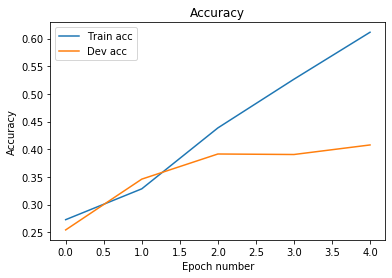

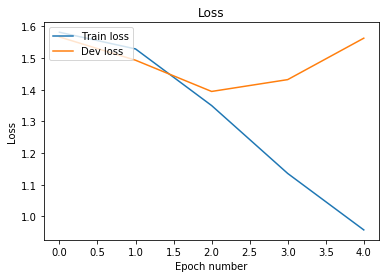

In [83]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)

from tensorflow.keras.utils import to_categorical
bs = 64
n_epochs = 5
x_train = x_train_int_pad 
x_dev = x_dev_int_pad 
y_train_oh = to_categorical(y_train)
y_dev_oh = to_categorical(y_dev)

history = model.fit(x_train, y_train_oh, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev_oh))

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['Train acc', 'Dev acc'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend(['Train loss', 'Dev loss'], loc='upper left')
plt.show()

In [84]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

x_test = x_test_int_pad
y_test = model.predict(x_test, batch_size=bs, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1)

f = open('logreg_lstm_y_test_sst.txt', 'w')
for item in y_test:
    f.write("%s\n" % np.argmax(item)) 
f.close()

## 4.3 - innovate !

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 200)         10000000  
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 128)               135680    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 645       
Total params: 10,136,325
Trainable params: 10,136,325
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 55s 6ms/sample - loss: 1.5704 - accuracy: 0.2779 - val_loss: 1.5093 - val_accuracy: 0.3551
Epoch 2/5
8544/8544 [===================

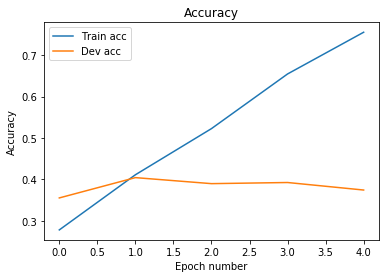

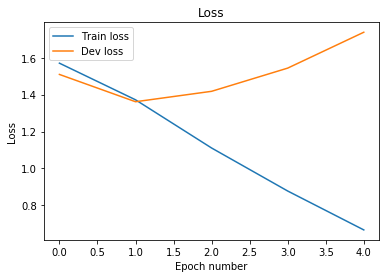

In [135]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.


from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Concatenate, Flatten, Dropout, AvgPool1D, Bidirectional, GlobalAveragePooling1D 


embed_dim  = 200 #52 #32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

#word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
#embedding_matrix = np.zeros((vocab_size, embed_dim))
#for w in word2vec.words:
#    id_w = tf.keras.preprocessing.text.one_hot(w, vocab_size)[0]
#    emb = word2vec.encode(w)
#    embedding_matrix[id_w] = emb

#from tensorflow.core.protobuf import rewriter_config_pb2
#from tensorflow.compat.v1.keras.backend import set_session

#tf.keras.backend.clear_session()

#config_proto = tf.compat.v1.ConfigProto()
#off = rewriter_config_pb2.RewriterConfig.OFF
#config_proto.graph_options.rewrite_options.arithmetic_optimization = off
#session = tf.compat.v1.Session(config=config_proto)
#set_session(session)

#model2 = Sequential()
#model2.add(Embedding(vocab_size, embed_dim))#, weights=[embedding_matrix]))
#model2.add(Bidirectional(LSTM(nhid, dropout=0.5, recurrent_dropout=0.2, kernel_regularizer=l2(1e-5))))
#model2.add(Dense(128, activation = 'relu'))
#model2.add(Dropout(0.5))
#model2.add(Dense(n_classes, activation='softmax'))

model2 = Sequential()
model2.add(Embedding(vocab_size, embed_dim))#, weights=[embedding_matrix]))
model2.add(Bidirectional(LSTM(nhid, dropout=0.5, recurrent_dropout=0.2, kernel_regularizer=l2(1e-5))))
model2.add(Dropout(0.5))
model2.add(Dense(n_classes, activation='softmax'))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

model2.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

print(model2.summary())

bs = 64
n_epochs = 5

history2 = model2.fit(x_train, y_train_oh, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev_oh))

import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['Train acc', 'Dev acc'], loc='upper left')
plt.show()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend(['Train loss', 'Dev loss'], loc='upper left')
plt.show()



In [144]:
x_test = x_test_int_pad
y_test = model2.predict(x_test, batch_size=bs, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1)
f = open('logreg_bidirectionallstm_y_test_sst.txt', 'w')
for item in y_test:
    f.write("%s\n" % np.argmax(item)) 
f.close()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, None, 200)         10000000  
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 128)         128128    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
dense_29 (Dense)             (None, None, 5)           645       
Total params: 10,128,773
Trainable params: 10,128,773
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/3
8544/8544 [==============================] -

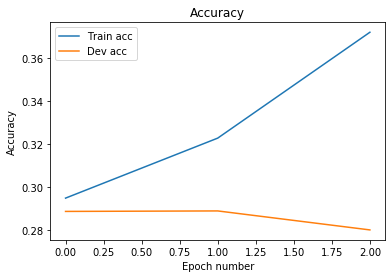

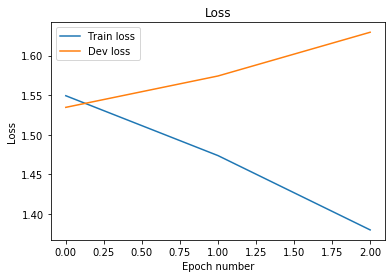

In [150]:
model3 = Sequential()
model3.add(Embedding(vocab_size, embed_dim))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(MaxPooling1D(5))
model3.add(Dropout(0.2))
model3.add(Dense(n_classes, activation='sigmoid'))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

model3.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model3.summary())
          
bs = 1
n_epochs = 3
          
history3 = model3.fit(x_train, y_train_oh, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev_oh))

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['Train acc', 'Dev acc'], loc='upper left')
plt.show()
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend(['Train loss', 'Dev loss'], loc='upper left')
plt.show()



Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 200)         10000000  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          19232     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          4128      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, None, 32)        

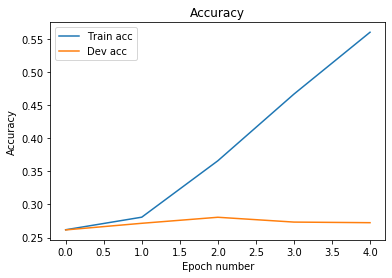

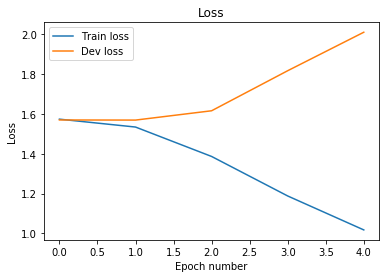

In [130]:
model4 = Sequential()
model4.add(Embedding(vocab_size, embed_dim))
model4.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Dropout(0.3))
model4.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Dropout(0.3))
model4.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Dropout(0.3))
model4.add(LSTM(nhid,dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(1e-5)))
model4.add(Dense(n_classes, activation='softmax'))
model4.compile(loss=loss_classif, optimizer=optimizer, metrics=metrics_classif)

print(model4.summary())

bs = 64
n_epochs = 5

history4 = model4.fit(x_train, y_train_oh, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev_oh))

plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['Train acc', 'Dev acc'], loc='upper left')
plt.show()
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend(['Train loss', 'Dev loss'], loc='upper left')
plt.show()



Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, None, 200)         10000000  
_________________________________________________________________
global_average_pooling1d_3 ( (None, 200)               0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 1005      
Total params: 10,001,005
Trainable params: 10,001,005
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 16s 2ms/sample - loss: 1.5739 - accuracy: 0.2851 - val_loss: 1.5650 - val_accuracy: 0.2970
Epoch 2/10
8544/8544 [=================

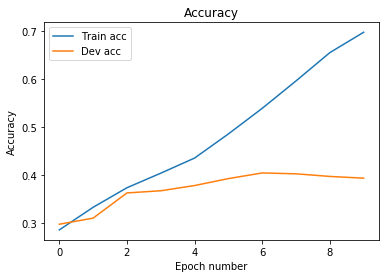

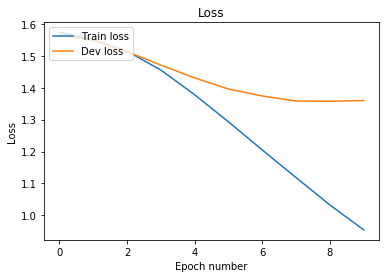

In [149]:
model5 = Sequential()
model5.add(Embedding(vocab_size, embed_dim))#, weights=[embedding_matrix]))
model5.add(GlobalAveragePooling1D())
model5.add(Dropout(0.5))
model5.add(Dense(n_classes, activation='softmax'))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

model5.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

print(model5.summary())

bs = 64
n_epochs = 10

history5 = model5.fit(x_train, y_train_oh, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev_oh))

plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['Train acc', 'Dev acc'], loc='upper left')
plt.show()
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend(['Train loss', 'Dev loss'], loc='upper left')
plt.show()

